# __Physical Activity Monitoring__

by Sai Myana, candidate no: 277239

# Introduction

Nine volunteers wearing three inertial measurement units (IMUs) and a heart rate monitor participated in eighteen various physical activities (such as walking, cycling, and soccer) that are included in the PAMAP2 Physical Activity Monitoring dataset.

# The aim of the report

The exercise's objectives were to use real-world data analysis techniques to this dataset and generate discoveries that a wearable technology manufacturer may find valuable.

We want our product to be superior to our main competitors such as Wireless InertiaCube3 by InterSense, MTw Awinda by Xsens, T40s by Vicon, and OptoTrak 3020 by Optotrak Certus. 

So, the goal is to develop hardware and/or software which can lower the cost and that will be able to predict type of activity that the user is performing and what should be the heartrate.

# Overview

This report is about a dataset called PAMAP2, which keeps track of different physical activities like lying, sitting, and walking. There are 18 activities in total, recorded from 9 people (8 men and 1 woman). The data is collected using 3 motion sensors and a heart rate monitor. The goal is to develop hardware and/or software which can lower the cost and that will be able to predict type of activity that the user is performing.

We have to carry out 4 specific activities such as:
1. Data Cleaning and wrangling 
2. Exploratory data analysis of the Physical Activity Monitoring data.
3. Develop and test at least one model which uses multiple attributes to make predictions.
4. Actionable recommendations based on the analyses

This report will cover a number of procedures, such as reading the data, data cleaning, hypothesis testing, and eda and building a predective model.

Firstly, the data will be read from individual files and it will be concatenated to make a single dataset, which will be easier for us to do the analysis.

Secondly, the data will cleaned for example removing Nans or back-filling or forward-filling the rows.

Thirdly, the EDA(Exploratory Data Analysis) will give us some insights about the data and its correlations. We will be plotting multiple graphs to analyse the data.

Finally, I will summarize the above report and build the model to predict physical activities. I will be using SequentialFeatureSelector from sklearn which basically selects fewest number of independent variables to explain the most variation, according to AIC score. After that, I'll begin modeling using linear regression. I will be developing two models one to predict the type of activity( low or high intensity tasks) and the second to predict the heartrate.

# Importing Packages

In [1]:
import pandas as pd 
import numpy as np
import scipy 
import matplotlib
from matplotlib import pyplot as plt 
import seaborn as sns 
import statsmodels
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


# Importing Dataset

Here I'll be reading the .dat files of every individual and concat it to make only one dataset and call it `df`. Also I'll be adding a new caloumn called `SubjectID` and put the subject number respectively.

In [2]:
files = ['Dataset/Protocol/subject101.dat', 'Dataset/Protocol/subject102.dat','Dataset/Protocol/subject103.dat','Dataset/Protocol/subject104.dat','Dataset/Protocol/subject105.dat','Dataset/Protocol/subject106.dat',
         'Dataset/Protocol/subject107.dat','Dataset/Protocol/subject108.dat','Dataset/Protocol/subject109.dat',]

df = pd.DataFrame()

for file in files:
    temp=pd.read_csv(file , sep=' ',header=None, names=['timestamp', 'activityID', 'heartrate_bpm', 'temp_hand','h_acc1_x','h_acc1_y','h_acc1_z','h_acc2_x','h_acc2_y','h_acc2_z',
                                           'h_gyro_x','h_gyro_y','h_gyro_z','h_magneto_x','h_magneto_y','h_magneto_z','h_orient1','h_orient2','h_orient3','h_orient4','temp_chest','c_acc1_x','c_acc1_y',
                                           'c_acc1_z','c_acc2_x','c_acc2_y','c_acc2_z','c_gyro_x','c_gyro_y','c_gyro_z','c_magneto_x','c_magneto_y','c_magneto_z','c_orient1','c_orient2','c_orient3',
                                          'c_orient4','temp_ankle','a_acc1_x','a_acc1_y','a_acc1_z','a_acc2_x','a_acc2_y','a_acc2_z','a_gyro_x','a_gyro_y','a_gyro_z','a_magneto_x','a_magneto_y',
                                           'a_magneto_z','a_orient1','a_orient2','a_orient3','a_orient4'])
    temp['SubjectID']=int(file[-5])

    df = pd.concat([df, temp], ignore_index=True)

## Activity Data 

In [3]:
activityID_val = {1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

## MET Data 

The estimated metabolic equivalent of task (MET) value for each recorded activity is specified in the dataset papers. Activities can be categorized into broad intensity groups and the number of calories burned per minute (MET) can be used to calculate this.

Since we have limited data, we will be predciting what type of activity the subject might be performing and not the actual individual activity since this needs lot more features and data if lot more subjects.

We can therefore categorise the activites in the dataset into two catogories:

Low intensity activities:

1. Lying down - 1 MET

2. Sitting - 1.8 MET

3. Standing - 1.8 MET

9. Watching TV (sitting or lying down) - MET unknown

10. Computer work (sitting or standing) - MET unknown

11. Car driving (sitting) - MET unknown

17. Ironing (standing) - 2.3 MET

18. Folding Laundry (standing) - MET unknown

13. Descending stairs - 3 MET

High intensity activities:

16. Vacuuming - 3.5 MET

4. Walking - 3.3-3.8 MET

6. Cycling - 4 MET

7. Nordic Walking - 5-6 MET

19. House cleaning (similar to walking and vacuuming)

5. Running - 7-8 MET

12. Ascending stairs - 8 MET

20. playing	soccer (similar to running) - 7-8 MET

24. Rope jumping - 8-10 MET

# I. Data Cleaning and Wrangling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 55 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      float64
 1   activityID     int64  
 2   heartrate_bpm  float64
 3   temp_hand      float64
 4   h_acc1_x       float64
 5   h_acc1_y       float64
 6   h_acc1_z       float64
 7   h_acc2_x       float64
 8   h_acc2_y       float64
 9   h_acc2_z       float64
 10  h_gyro_x       float64
 11  h_gyro_y       float64
 12  h_gyro_z       float64
 13  h_magneto_x    float64
 14  h_magneto_y    float64
 15  h_magneto_z    float64
 16  h_orient1      float64
 17  h_orient2      float64
 18  h_orient3      float64
 19  h_orient4      float64
 20  temp_chest     float64
 21  c_acc1_x       float64
 22  c_acc1_y       float64
 23  c_acc1_z       float64
 24  c_acc2_x       float64
 25  c_acc2_y       float64
 26  c_acc2_z       float64
 27  c_gyro_x       float64
 28  c_gyro_y       float64
 29  c_gyro_z      

We have `2872533 rows` of data before data cleaning 

In [5]:
df.head()

,timestamp,activityID,heartrate_bpm,temp_hand,h_acc1_x,h_acc1_y,h_acc1_z,h_acc2_x,h_acc2_y,h_acc2_z,...,a_gyro_y,a_gyro_z,a_magneto_x,a_magneto_y,a_magneto_z,a_orient1,a_orient2,a_orient3,a_orient4,SubjectID
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1


Dropping 3D-acceleration data (ms-2)(scale: ±6g, resolution: 13-bit), sometimes it gets saturated due to high impacts caused by certain movements (e.g. during running) with acceleration over 6g.

Dropping orientation columns since it is invalid in this dataset.

Dropping rows where 'activityID'=0 and null because this data mainly covers transient activities between performing different activities,e.g. going from one location to the next activity's location, or waiting for the preparation of some equipment

In [6]:
df.drop(columns=['h_acc2_x','h_acc2_y','h_acc2_z','c_acc2_x','c_acc2_y','c_acc2_z','a_acc2_x','a_acc2_y','a_acc2_z'], inplace=True)
df.drop(columns=['h_orient1','h_orient2','h_orient3','h_orient4','c_orient1','c_orient2','c_orient3','c_orient4','a_orient1','a_orient2','a_orient3','a_orient4'], inplace=True)
df.drop(df[df.activityID==0].index,inplace=True)

The use of wireless sensors is causing data drops. But this only happened very rarely. Hardware setup issues, such as losing connection to the dongles or crashing the system. Owing to these issues, several activities are either entirely or partially absent for specific courses. So I removed the data wher all the rows were filled with Nans.

## Removing Nans and filling the Nans

In [7]:
df.drop(df[df.h_acc1_x.isnull() | df.h_acc1_y.isnull() | df.h_acc1_z.isnull() | df.c_acc1_x.isnull() | df.c_acc1_y.isnull() | df.c_acc1_z.isnull() | df.a_acc1_x.isnull() | df.a_acc1_y.isnull() | df.a_acc1_z.isnull()
        | df.h_magneto_x.isnull() | df.h_magneto_y.isnull() | df.h_magneto_z.isnull() | df.c_magneto_x.isnull() | df.c_magneto_y.isnull() | df.c_magneto_z.isnull() | df.a_magneto_x.isnull() | df.a_magneto_y.isnull() 
        | df.a_magneto_z.isnull()].index,inplace=True)

df.reset_index(drop=True,inplace=True)

Since the data was given every 0.01s beacuse IMUs have a sampling frequency	of around 100Hz, but the sampling frequency of the HR-monitor was only approximately 9Hz, the missing Heartrate-values were also indicated with NaN. So to overcome this we could either remove the complete row or we can do backfill and forwardfill the dataset. For example, if I had (-1, NaN, 1), then using forward fill will would get (-1, -1, 1) whilst with backward fill  would get (-1, 1, 1). So we can use forward fill the to remove Nans from heartrate column and then use back fill for the first rows of Nan values.

In [8]:
df['heartrate_bpm'].fillna(method='ffill', inplace=True)
df['heartrate_bpm'].fillna(method='bfill', inplace=True)

## Calculating resultant values

Acceleration

The definition of acceleration is the rate at which velocity changes over time. Vector quantities are accelerations. The direction of the net force acting on an object determines the direction of its acceleration. All three spatial axes of acceleration can be measured by triaxial accelerometers. The accelerometer's orientation and the force vector's direction determine the readings along each axis.

Acceleration at P is given by  $\vec{A} =ax\hat{i}+ay\hat{j}+az\hat{k} $
   where,  $\hat{i},\hat{j},\hat{k}$
  are unit vectors along x,y and z.

$A=a^2x+a^2y+a^2z$
   gives the magnitude of the resultant acceleration.

**2.2. Angular velocity**

Angular velocity measures the rate of change of the angular position of an object that is rotating or revolving relative to a point. The direction of angular velocity is perpendicular to the plane of rotation of the object. Angular velocity can be measured with a triaxial gyroscope.

$\vec{ω} =ωx\hat{i}+ωy\hat{j}+ωz\hat{k} $
 
Magnitude of resultant,  $ω=ω^2x+ω^2y+ω^2z$ 


So making the changes accordingly on our dataset. And then dropping the individual columns.

In [9]:
df['acc_hand'] = ((df.h_acc1_x**2)+(df.h_acc1_y**2)+(df.h_acc1_z**2))**0.5
df['acc_chest'] = ((df.c_acc1_x**2)+(df.c_acc1_y**2)+(df.c_acc1_z**2))**0.5
df['acc_ankle'] = ((df.a_acc1_x**2)+(df.a_acc1_y**2)+(df.a_acc1_z**2))**0.5
df['gyr_hand'] = ((df.h_gyro_x**2)+(df.h_gyro_y**2)+(df.h_gyro_z**2))**0.5
df['gyr_chest'] = ((df.c_gyro_x**2)+(df.c_gyro_y**2)+(df.c_gyro_z**2))**0.5
df['gyr_ankle'] = ((df.a_gyro_x**2)+(df.a_gyro_y**2)+(df.a_gyro_z**2))**0.5

In [10]:
df.drop(columns=['h_acc1_x','h_acc1_y','h_acc1_z','c_acc1_x','c_acc1_y','c_acc1_z','a_acc1_x','a_acc1_y','a_acc1_z',
                 'h_gyro_x','h_gyro_y','h_gyro_z','c_gyro_x','c_gyro_y','c_gyro_z','a_gyro_x','a_gyro_y','a_gyro_z',
                'h_magneto_x','h_magneto_y','h_magneto_z','c_magneto_x','c_magneto_y','c_magneto_z','a_magneto_x','a_magneto_y','a_magneto_z'], inplace=True)

df.reset_index(drop=True,inplace=True)

## Activity type

I'am adding a new column which will distinguish the activities as high or low. So, based on this, the column name `activity_high` will have either have value `0 for low activity` or `1 for high activity`

In [11]:
low_acts = [1, 2, 3, 9, 10, 11, 17, 18, 13]
high_acts=[16, 4, 6, 7, 19, 5, 12, 20, 24]

df["activity_high"]=0

df['activity_high'] = np.where(df['activityID'].isin(high_acts), 1, 0)

activitytype={0:"Low intensity", 1:"High intensity"}

## Final `df`

After data cleaning, wrangling abd other necessary steps, we get the following final dataset `df`

In [12]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921431 entries, 0 to 1921430
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   timestamp      1921431 non-null  float64
 1   activityID     1921431 non-null  int64  
 2   heartrate_bpm  1921431 non-null  float64
 3   temp_hand      1921431 non-null  float64
 4   temp_chest     1921431 non-null  float64
 5   temp_ankle     1921431 non-null  float64
 6   SubjectID      1921431 non-null  int64  
 7   acc_hand       1921431 non-null  float64
 8   acc_chest      1921431 non-null  float64
 9   acc_ankle      1921431 non-null  float64
 10  gyr_hand       1921431 non-null  float64
 11  gyr_chest      1921431 non-null  float64
 12  gyr_ankle      1921431 non-null  float64
 13  activity_high  1921431 non-null  int32  
dtypes: float64(11), int32(1), int64(2)
memory usage: 197.9 MB


After data cleaning and wrnagling, now we have `1921431 rows` and earler we had `2872533`. So we removed `951,102 rows` of Nans

In [13]:
df.head(5)

,timestamp,activityID,heartrate_bpm,temp_hand,temp_chest,temp_ankle,SubjectID,acc_hand,acc_chest,acc_ankle,gyr_hand,gyr_chest,gyr_ankle,activity_high
0,37.66,1,100.0,30.375,32.1875,30.75,1,10.230952,9.791172,9.912723,0.039483,0.066375,0.027921,0
1,37.67,1,100.0,30.375,32.1875,30.75,1,9.855324,9.791979,9.879026,0.173852,0.067424,0.021749,0
2,37.68,1,100.0,30.375,32.1875,30.75,1,9.496016,9.907409,9.885166,0.238506,0.060338,0.063439,0
3,37.69,1,100.0,30.375,32.1875,30.75,1,9.526437,9.879549,9.839102,0.194311,0.090952,0.046244,0
4,37.70,1,100.0,30.375,32.1875,30.75,1,9.751993,9.875840,9.956473,0.072467,0.041521,0.049304,0


# II. Exploratory Data Analysis

In [14]:
df.describe() 

,timestamp,activityID,heartrate_bpm,temp_hand,temp_chest,temp_ankle,SubjectID,acc_hand,acc_chest,acc_ankle,gyr_hand,gyr_chest,gyr_ankle,activity_high
count,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06,1.921431e+06
mean,1.695395e+03,8.093297e+00,1.073271e+02,3.276112e+01,3.618118e+01,3.371458e+01,4.568415e+00,1.096306e+01,1.017987e+01,1.236644e+01,1.506269e+00,5.182076e-01,1.415635e+00,5.270785e-01
std,1.091504e+03,6.176248e+00,2.696829e+01,1.790635e+00,1.493024e+00,1.092284e+00,2.332766e+00,5.640951e+00,3.815284e+00,7.650555e+00,1.712160e+00,5.919752e-01,1.903787e+00,4.992663e-01
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,3.193750e+01,3.000000e+01,1.000000e+00,1.439679e-01,6.147588e-02,9.764158e-02,5.192451e-04,4.477602e-04,5.792568e-04,0.000000e+00
25%,7.394450e+02,3.000000e+00,8.600000e+01,3.168750e+01,3.518750e+01,3.300000e+01,2.000000e+00,9.443975e+00,9.474023e+00,9.859592e+00,1.642410e-01,9.440974e-02,5.768535e-02,0.000000e+00
50%,1.467160e+03,6.000000e+00,1.040000e+02,3.318750e+01,3.643750e+01,3.406250e+01,5.000000e+00,9.797916e+00,9.828833e+00,1.004271e+01,9.734296e-01,3.655575e-01,5.211401e-01,1.000000e+00
75%,2.654610e+03,1.300000e+01,1.240000e+02,3.406250e+01,3.743750e+01,3.450000e+01,7.000000e+00,1.126501e+01,1.038797e+01,1.167463e+01,2.231572e+00,7.028865e-01,2.111620e+00,1.000000e+00
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,3.856250e+01,3.543750e+01,9.000000e+00,2.198549e+02,1.557281e+02,2.621491e+02,3.767916e+01,1.868213e+01,3.431539e+01,1.000000e+00


As we can see from here the minimum heartrate in bpm is 57, maximumn is 202 and mean is 107.32. Maximum acceleration is 262.14 for the sensor located on the ankle which could indicate activities related to running. 

Let's see the values of heartrate if there are any wrong values by looking at all the unique values of the dataset. Since the data was collected by a device, the chances of colleting wrong values could be zero.

In [15]:
pd.unique(df.heartrate_bpm)

array([100., 101., 102., 103., 104., 105., 106., 107.,  99.,  98.,  97.,
        96.,  95.,  94.,  93.,  92.,  91.,  90.,  89.,  88.,  87.,  86.,
        85.,  84.,  83.,  82.,  81.,  80.,  79.,  78., 108., 109., 110.,
       111., 112., 113., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.,
       167., 114., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183.,  77.,  76.,  75.,  74.,
        73.,  72.,  71.,  70.,  69.,  68.,  67.,  66.,  65.,  64.,  63.,
        62.,  61.,  60.,  59.,  58.,  57., 184., 185., 186., 187., 188.,
       189., 190., 191., 192., 193., 194., 195., 196., 197., 198., 199.,
       200., 201., 202.])

Lets check if our dataset is balanced or not

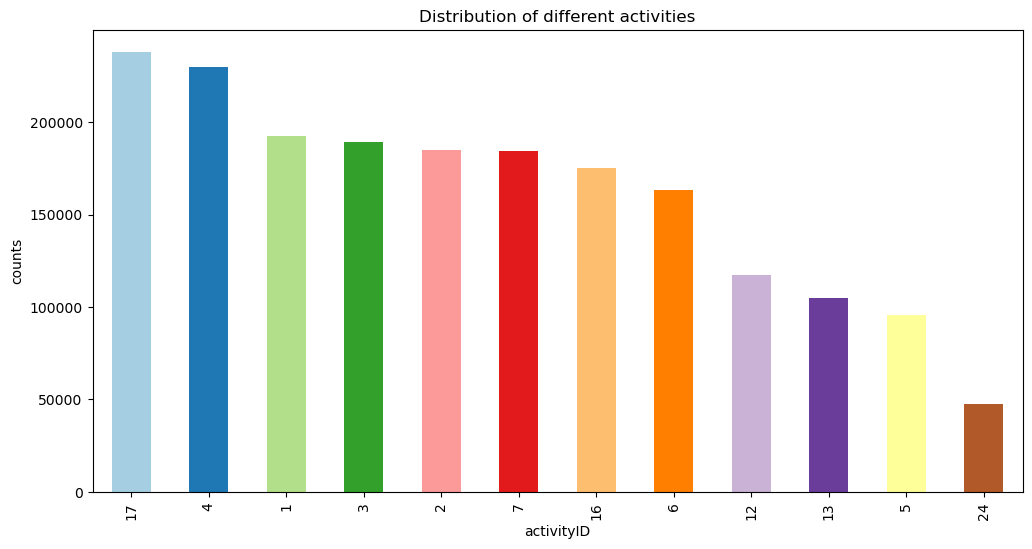

In [16]:
df['activityID'].value_counts().plot(kind = "bar",figsize = (12,6), color= plt.cm.Paired(range(len(df))))
plt.ylabel("counts")
plt.title('Distribution of different activities')
plt.show()

Plotting a bar chart that displays the average heart rate for each activity is necessary to determine which activities are the most difficult. In turn, this will assist us in further analyzing specific activity data. To make the outcomes analysis process easier, the activity names will be utilized. 

## Heartrate Analysis

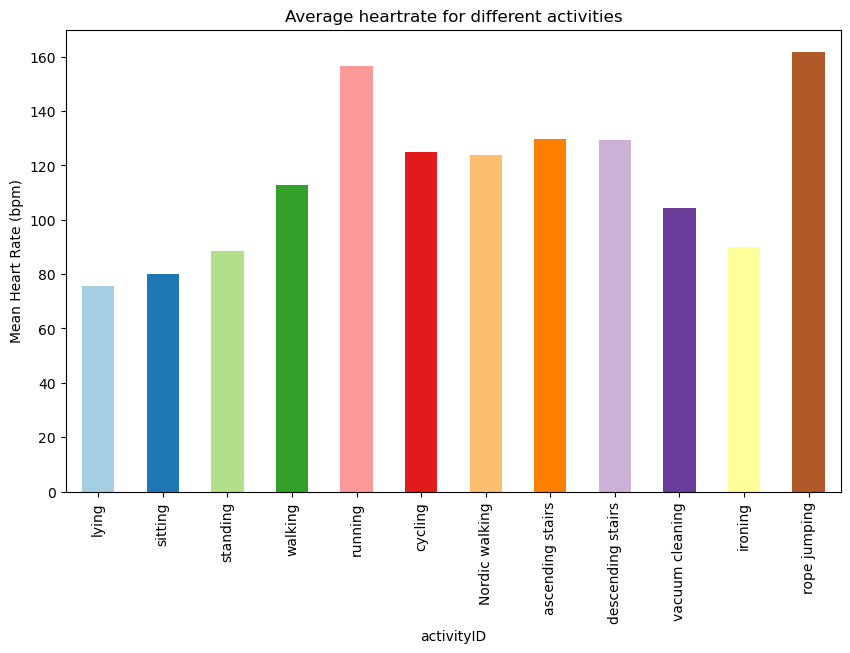

In [17]:
df_heartrate=df['heartrate_bpm'].groupby(df['activityID']).mean()
df_heartrate.index = df_heartrate.index.map(activityID_val)

df_heartrate.plot(kind = 'bar',figsize=(10,6), color= plt.cm.Paired(range(len(activityID_val))))
plt.ylabel("Mean Heart Rate (bpm)")
plt.title('Average heartrate for different activities')
plt.show()

The above barcharts tells us that activity `running` and `rope jumping` has the highest heartrate comapre to any other activities

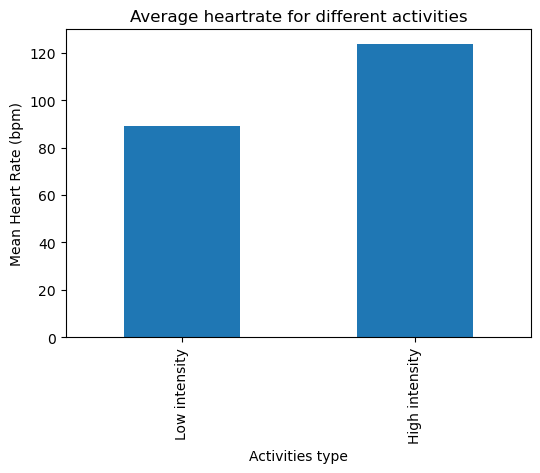

In [18]:
df_heartrate=df['heartrate_bpm'].groupby(df['activity_high']).mean()
df_heartrate.index = df_heartrate.index.map(activitytype)

df_heartrate.plot(kind = 'bar',figsize=(6,4))
plt.ylabel("Mean Heart Rate (bpm)")
plt.xlabel("Activities type")
plt.title('Average heartrate for different activities')
plt.show()

The above barcharts tells us that mean heartrate of high intensity activities is more than low internsity activities which makes perfect sense.

Lets plot the Spearman correlation graph to further analyse the data. 

<Axes: >

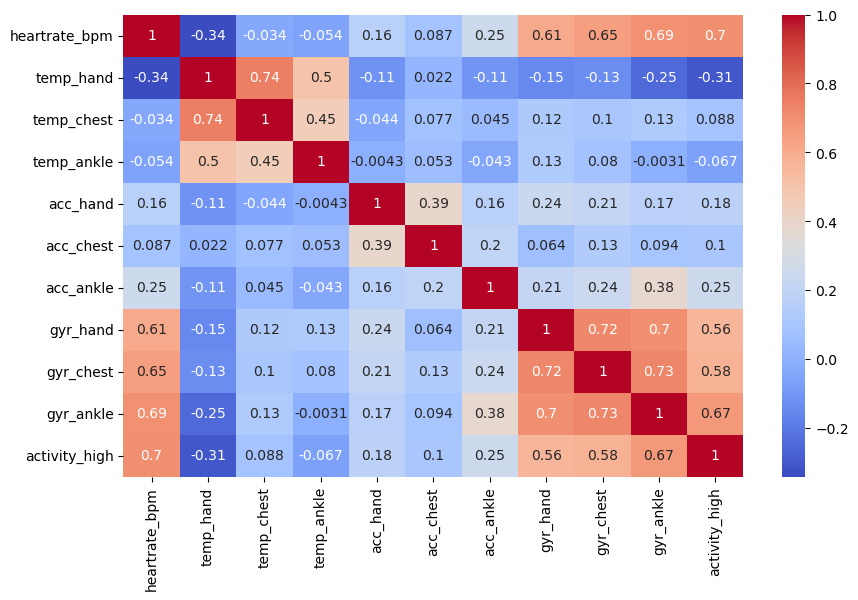

In [19]:
corr_df = df.drop(["timestamp","activityID","SubjectID"],axis=1)
corr = corr_df.corr(method="spearman")

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=corr, cmap="coolwarm", annot = True)

The above heatmap shows the statistical similarity between the different columns, such as:
1. Temperature of hand has negative correlation with heartrate
2. Angular velocity of hand, chest and ankle has positive correlation with heartrate
3. Temperature of hand has positive correlation with temperature of chest and ankle.
4. Angular velocity of hand has a positve correlation with angular velocity of chest and ankle
5. Heartrate has positive correlation with angular velocity of ankle 
    

Let's plot histogram plot of all the parameters. A histogram plot is a great tool for quickly assessing a distribution of the dataset.

## Histogram plot

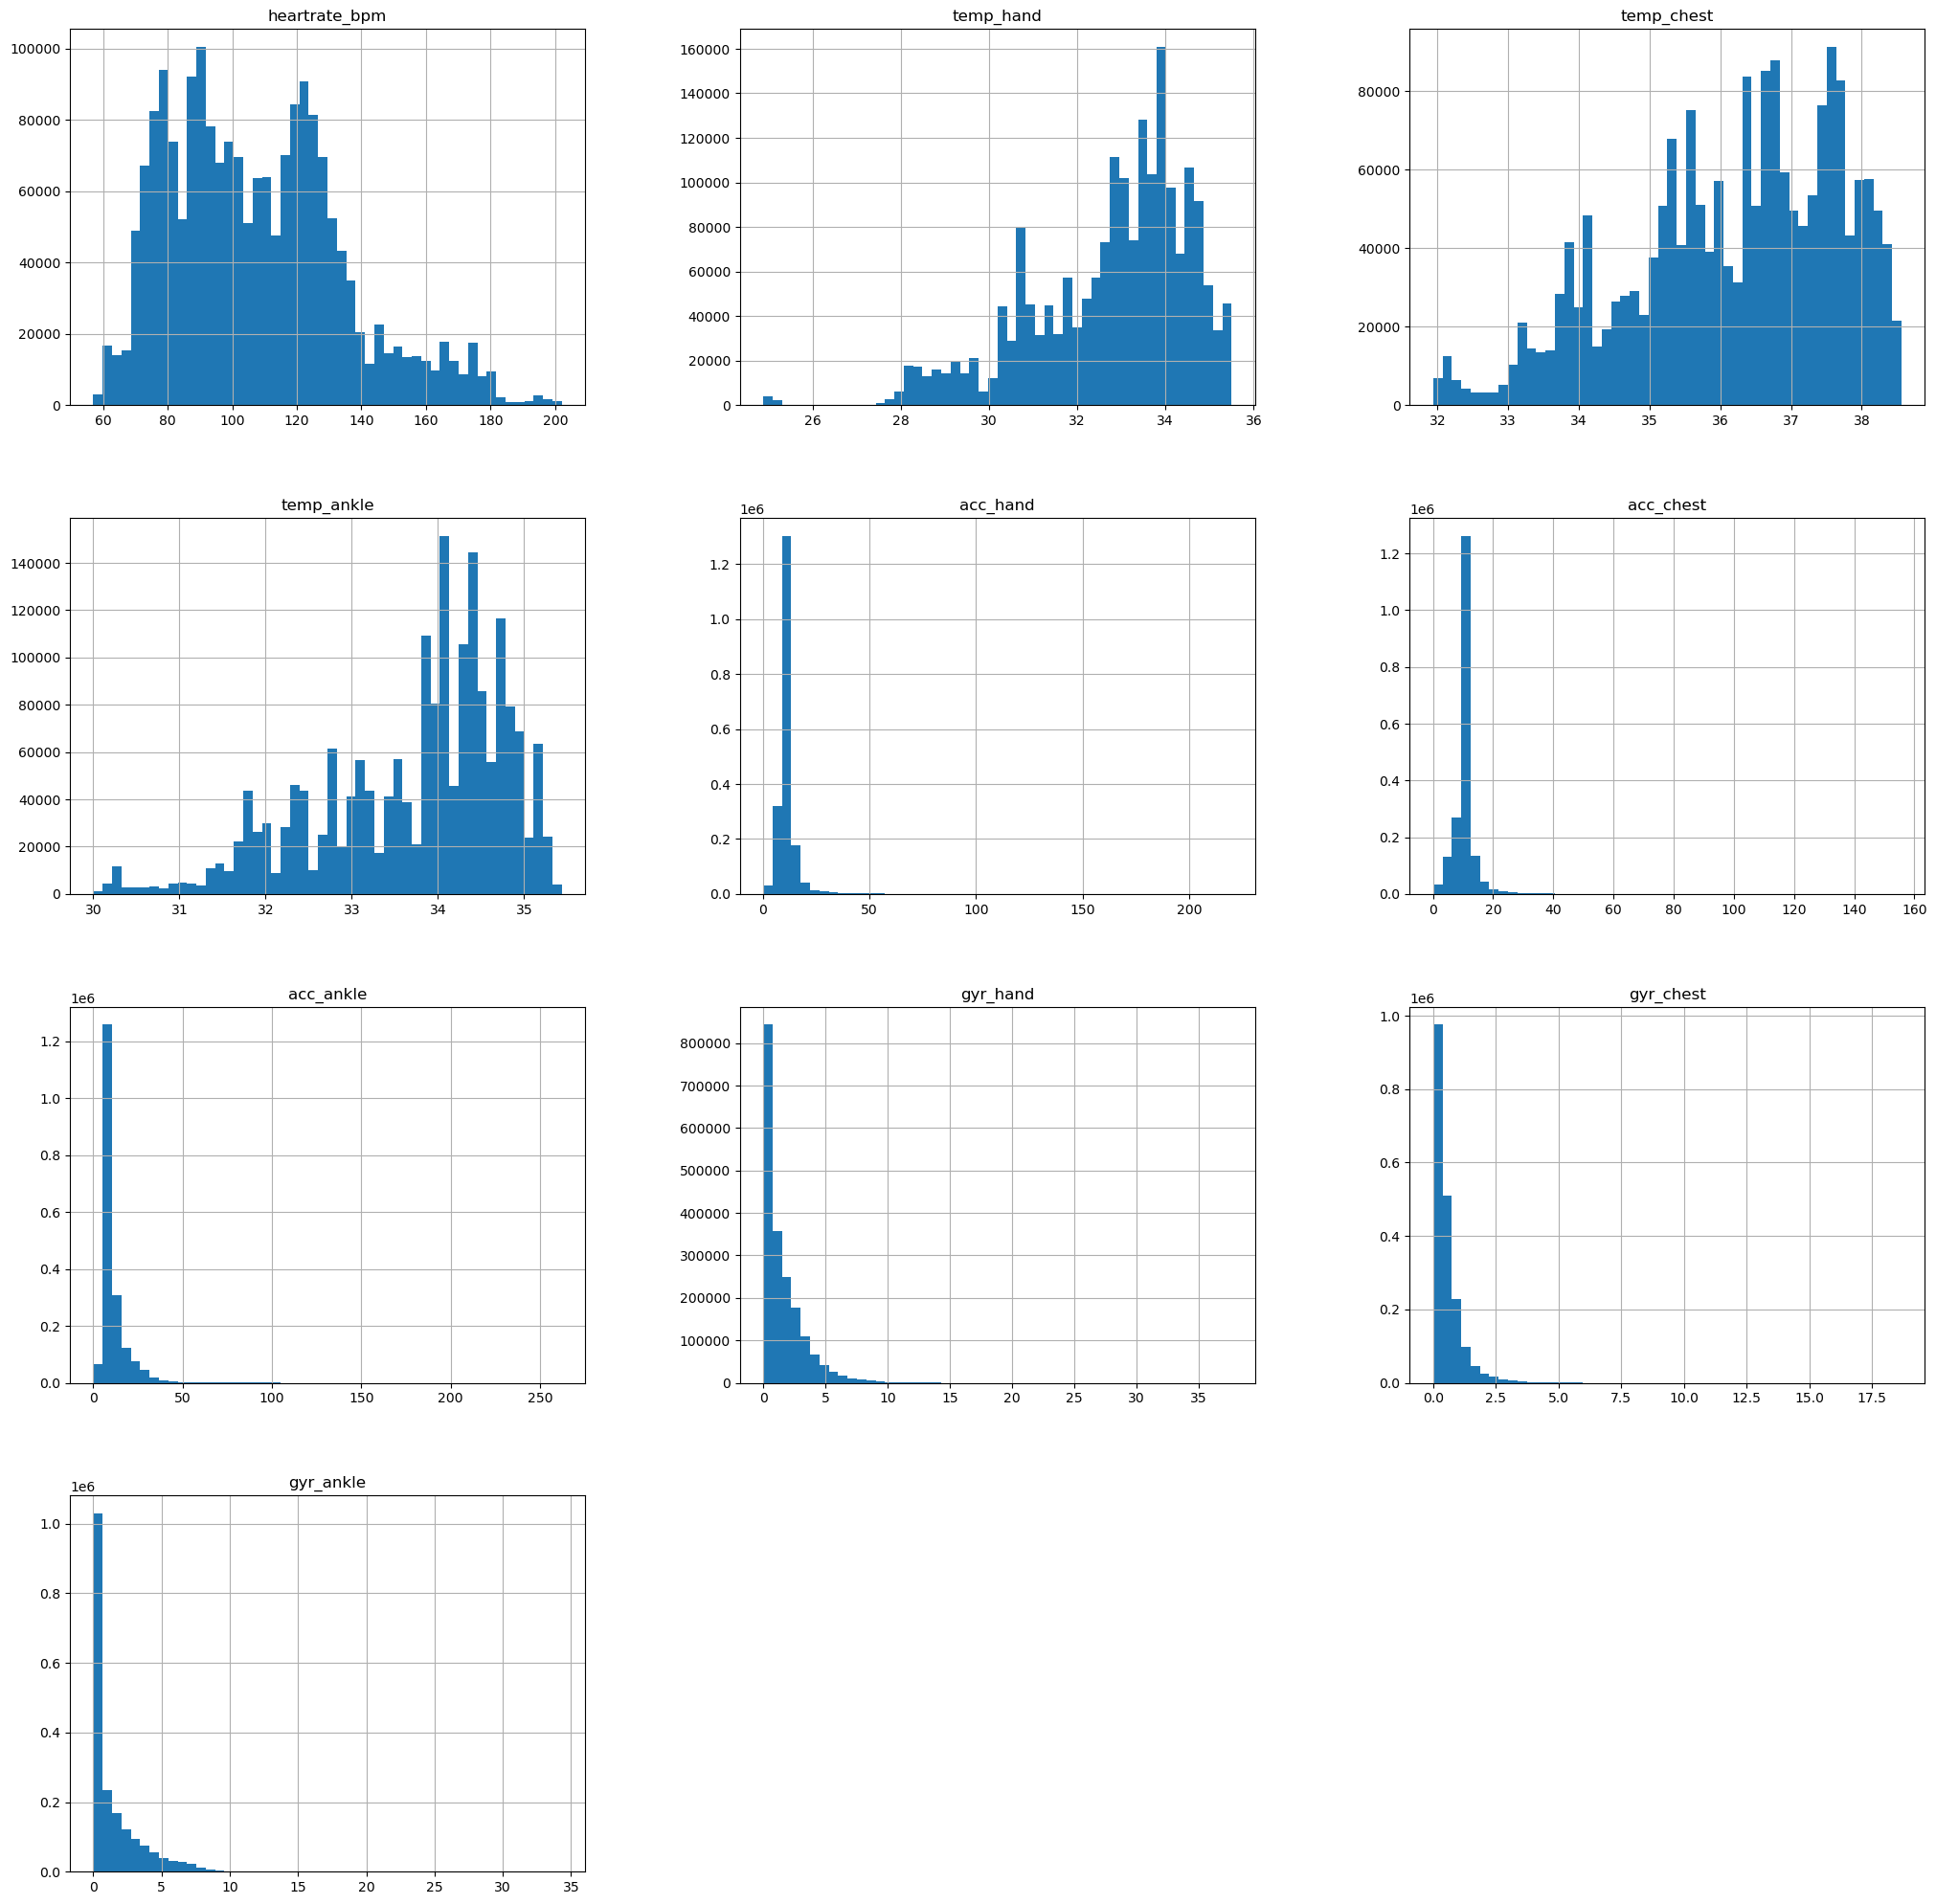

In [20]:
df1 = df.drop(['activityID','SubjectID','timestamp','activity_high'],axis = 1)
df1.hist(figsize = (25,25), bins = 50)
plt.show()

Most of the distribution is not normal or Gaussian. There seems to be some outliers in hand temperature data but as I said earlier the values recorded by the device so the chances of it being error is 0. So this outliers could be because of some activity an I will not remove it. 

## Acceleration analysis

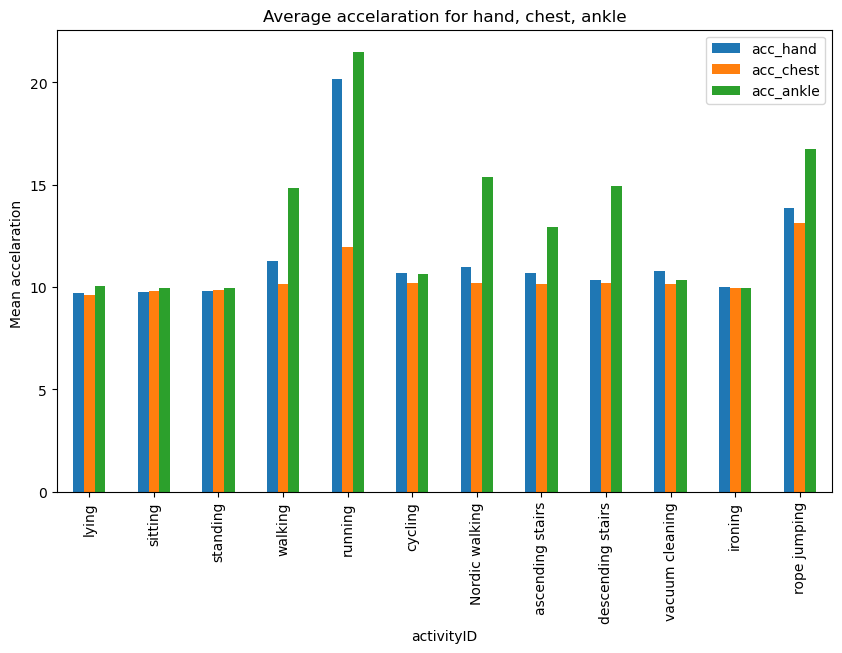

In [21]:
df2=df1[['acc_hand','acc_chest','acc_ankle']].groupby(df['activityID']).mean()

df2.index = df2.index.map(activityID_val)

df2.plot(kind = 'bar',figsize=(10,6))
plt.ylabel("Mean accelaration ")
plt.title('Average accelaration for hand, chest, ankle')
plt.show()

Naturally, the mean acceleration of various body parts is very low when engaging in low physical tasks such as sitting, standing, lying down, and ironing. Whereas, physically demanding exercises with a high mean acceleration value for the ankle and hand include running and rope jumping. Other sports involving significant leg motions, such as walking, Nordic walking, and ascending and descending stairs, also has high ankle acceleration.

The chest acceleration is low for almost all activities except for rope jumping.

## Angular velocity analysis

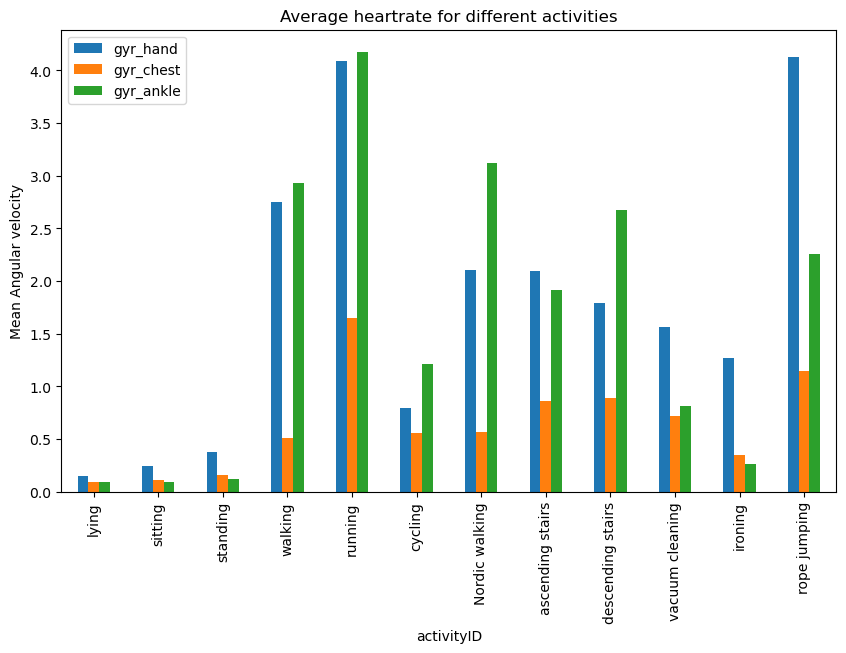

In [22]:
df2=df1[['gyr_hand','gyr_chest','gyr_ankle']].groupby(df['activityID']).mean()

df2.index = df2.index.map(activityID_val)

df2.plot(kind = 'bar',figsize=(10,6))
plt.ylabel("Mean Angular velocity")
plt.title('Average heartrate for different activities')
plt.show()

From the above graph we can observe that lying, sitting, standing, and ironing except for hand, the angular velocity is less since these are less physical activities. Running has the highest angular velocity compared to other activities. Rope jumping has high hand angular acceleration. Nordic walking has less hand angular velocity than simple walking.

## Temperature analysis

Since the temperature data is close to each other, it can be difficult to make sense from the plotted graph. To overcome this we can use min-max scaling to scale the values between 0-1. Min-max scaling preserves the shape of the data and improves the numerical stability. 

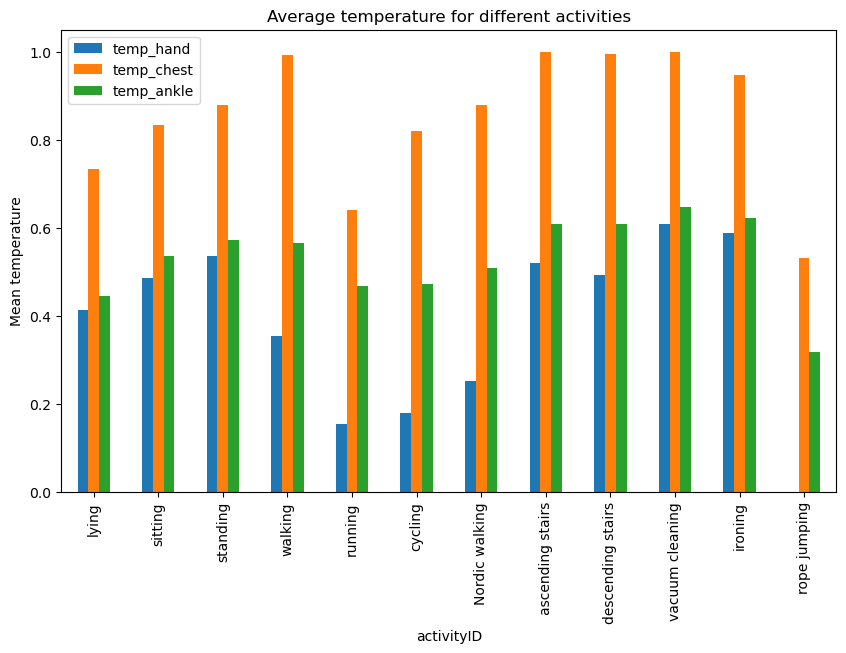

In [23]:
df2=df[['temp_hand','temp_chest','temp_ankle']].groupby(df['activityID']).mean()
df2.index = df2.index.map(activityID_val)
max_u = np.max(df2)
min_u = np.min(df2)
v = (df2 - min_u)/(max_u - min_u)

v.plot(kind = 'bar',figsize=(10,6))
plt.ylabel("Mean temperature")
plt.title('Average temperature for different activities')
plt.show()

The above graph tells us that, activity vacuum cleaner has high hand temeprature compared to any other activity, this could be because of the vacuum cleaning machine held in the hand generates heat.

Running has least temperature for all sensors, this could be because, running increases the contact with the fresh air and thereby reducing the temperature of the body/sensor. which is also evident from sensor values of rope jumping which also has low temperatures. Infact the hand temperature for rope jumping is the least.

It is interesting to observe that, in comparison to other activities, the hand temperature is significantly lower during activities involving vigorous hand movement.

,heartrate_bpm,temp_hand,temp_chest,temp_ankle,acc_hand,acc_chest,acc_ankle,gyr_hand,gyr_chest,gyr_ankle
SubjectID,,,,,,,,,,
1,121.972541,32.429376,35.233075,33.663177,11.181471,10.325902,12.553408,1.678398,0.573528,1.382937
2,109.255777,32.364107,36.351528,34.265277,10.807493,10.221734,12.100619,1.829844,0.593202,1.496622
3,95.011613,31.893264,35.796654,33.527497,10.677672,9.943247,11.812926,1.469106,0.397185,0.999533
4,109.349883,31.916960,35.120806,33.581053,10.251104,9.985871,11.535957,1.178037,0.449995,1.145463
5,108.381941,34.772649,37.443408,34.204382,11.076624,10.285235,12.828242,1.512746,0.548426,1.605385
6,102.914886,32.308952,35.836247,34.723591,11.920546,10.194948,12.511565,1.670730,0.604622,1.534721
7,96.304319,32.946743,36.759055,32.233200,10.379291,10.021997,12.400005,1.037690,0.407965,1.428140
8,109.793673,33.166299,36.708806,33.354324,11.129032,10.290483,12.775475,1.545575,0.502305,1.539173
9,148.524428,25.051274,32.235652,31.423211,14.367001,12.365645,17.713336,3.107103,1.049296,2.258199


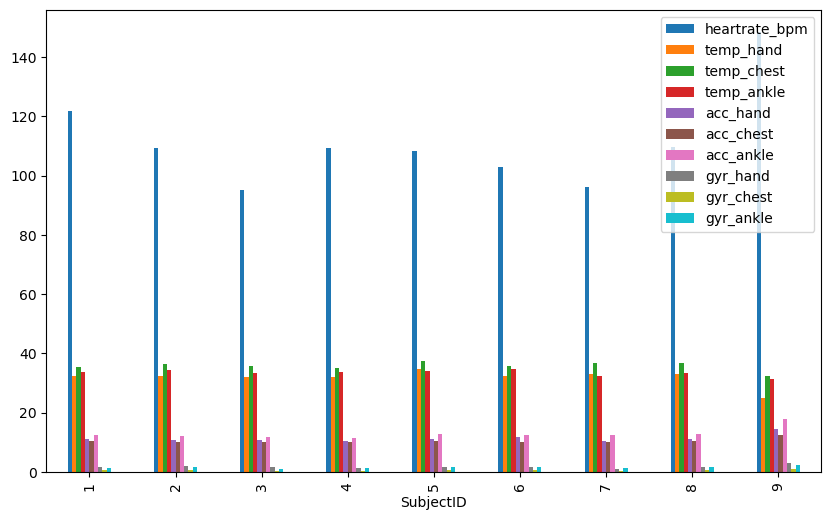

In [24]:
df2=df1.groupby(df['SubjectID']).mean()
df2.plot(kind = 'bar',figsize=(10,6)).legend(loc='best')

df2.head(10)

The subject 9 has the highest meann heartrate and that is because the person has performed only 6 activities and most of them are high intensity activites. 

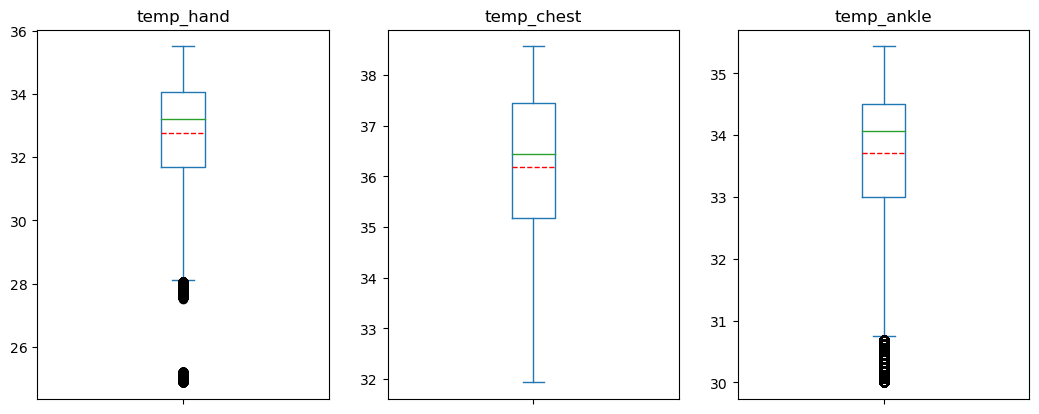

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 3)

df_cols = ['temp_hand','temp_chest','temp_ankle']

for col, ax in zip(df_cols,axes.flat):
    df.plot(kind="box",ax=ax,y=col,meanline=True,showmeans=True,meanprops={"color":"r"})
    ax.set_xticklabels([""])
    ax.set_title(col)

fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 1)

Temperature of hand and ankle has outliers but that could be because of low intensity activities and we cannot remove them.

# III. Modelling

__Aikaike Information Criterion:__

Estimator of prediction error and thereby relative quality of a statistical model for a given set of data.
𝐴𝐼𝐶=2𝑘 −2ln⁡($\hat{ℒ}$)

Where 𝑘 is the number of estimated parameters, and $\hat{ℒ}$ is the maximised value of the likelihood function for the model. Note, ln⁡($\hat{ℒ}$) is called the log-likelihood.
Model selection is the process of choosing the model which has the smallest Aikaike Information Criterion. 

A mathematical technique called the Akaike information criterion (AIC) is used to assess how well a model matches the data it was created from. AIC is a statistical tool used to analyze various models and identify the best fit for the data. 

AIC is calculated from:
1. how many independent variables were included in the model's construction.
2. The model's highest likelihood estimate, which measures how accurately the model captures the data.

The model that uses the fewest number of independent variables to explain the most variation is the best-fit model, according to AIC.

__Linear Regression:__

To predict a variable's value based on the value of another variable, we use linear regression analysis. The dependent variable is the one you are trying to forecast. We refer to the variable you are using to forecast the value of the other variable as the independent variable.

Linear-regression models are quite straightforward and provide a simple mathematical method for generating predictions.

I dropped some features which would impact our modelling precision and analysis. The parameters such as 'SubjectID','timestamp','activityID' were dropped since these parameters are not necessary for our prediction and it may induce noise and predictions would be innacurate. Hence, it is recommended to remove them for model development and testing.

In [26]:
df3= df.drop(['SubjectID','timestamp','activityID'],axis = 1) # Dropping 'SubjectID','timestamp','activityID' 

We will bedoing linear regression for our prediction, where `activity_high` will be the response variable and all other features will be the independent variables. Here we are truing to predicth based on the dependent variables we will predict what type of activity the subject is performing, that is either high intensity(1) activities or low intensity(0) activities.

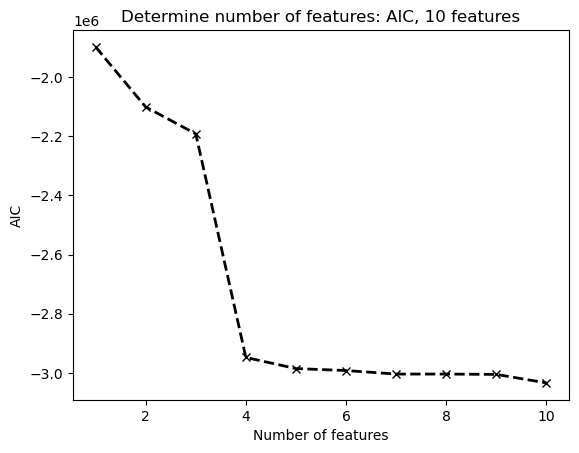

In [27]:
resp = "activity_high"

y = df3[resp]
X = df3.copy(deep=True)
X.drop(columns=[resp],inplace=True)

AIC = np.zeros(len(X.columns))
lm = LinearRegression()
num_features = np.arange(1,len(df3.columns))
sfs_features = {nf : {} for nf in num_features[:-1]}

for idx,nf in enumerate(num_features[:-1]):
    sfs = SequentialFeatureSelector(lm,n_features_to_select=nf).fit(X,y)
    features = sfs.get_feature_names_out()
    new_X = X[features]
    nf_lm = lm.fit(new_X,y)
    score = nf_lm.score(new_X,y)
    y_pred = nf_lm.predict(new_X)
    mse = mean_squared_error(y,y_pred)
    AIC[idx] = 2.0*nf + len(X) * np.log(2.0*np.pi*(mse ** 2.0)) + len(X)
    sfs_features[nf] = {"score":score, "features": features, "model":nf_lm}
    
nf_lm = lm.fit(X,y)
score = nf_lm.score(X,y)
y_pred = nf_lm.predict(X)
mse = mean_squared_error(y,y_pred)
AIC[-1] = 2.0*num_features[-1] + len(X) * np.log(2.0*np.pi*(mse ** 2.0)) + len(X)

aic_features = np.argmin(AIC) + 1
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_xlabel("Number of features")
ax.set_ylabel("AIC")
ax.set_title(f"Determine number of features: AIC, {aic_features} features")
ax.plot(num_features,AIC,ls="--",lw=2,marker="x",c="k")

## Predicting the type of activity

In [28]:
import statsmodels.api as sm

features = sfs_features[aic_features-1]["features"]

X2 = X[features]
feature = sm.add_constant(X2)

model = sm.OLS(y, feature)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          activity_high   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
No. Observations:             1921431   F-statistic:                 2.672e+05
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.5415      0.006   -245.298      0.000      -1.554      -1.529
heartrate_bpm     0.0072   1.25e-05    577.460      0.000       0.007       0.007
temp_hand        -0.1533      0.000   -635.380      0.000      -0.154      -0.153
temp_chest        0.1732      0.000    641.566      0.000       0.173       0.174
acc_hand         -0.0013   5.48e-05    -24.371      0.000      -0.001      -0.001
acc_chest         0.0007   7.69e-05      8.845      0.000       0.001       0.001
acc_ankle        -0.0020   3.62e-05    -55.959      0.000      -0.002      -0.002
gyr_hand          0.0198      0.000    104.428      0.000       0.019       0.020
gyr_chest         0.0408      0.001     75.325      0.000       0.040       0.042
gyr_ankle         0.0239      0.000    139.124      0.000       0.024       0.024
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the above graph and OLS regression results, we can see that temp_ankle has been removed. This is beacuse I used sklearn's feature selection model called SequentialFeatureSelector, which removes the features that are not necessary for our prediction. 

__Prediction:__

With the accuracy of our model being 55.6%(R-squared value), we can make some predictions with 95% confidence interval such as:
- For each decrease in the hand temperature, acceleration of hand and ankle, the chances of person performing high intensity tasks increases.
- For each increase in the heartrate,temperature and acceleration of chest, angular velocity of hand, chest and ankle, the chances of person performing high intensity tasks also increases.

But since want to make product which would be better than our competitors and it would be easy for common people to use.
We will test our model using only on four paremeters such as heartrate, hand temperature, hand acceleration and hand angular velocity. The reason for choosing those is because we can develope as device such as a smart watch were we can install some sensors to measure these parameters and make the prediction if the user is performing high intensity or low intensity tasks.

In [31]:
new_features = [f for f in features if not f in ["temp_chest","acc_chest","acc_ankle","gyr_chest","gyr_ankle"]]

X2 = X[new_features]
feature = sm.add_constant(X2)

model = sm.OLS(y, feature)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          activity_high   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
No. Observations:             1921431   F-statistic:                 3.751e+05
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5468      0.006     91.293      0.000       0.535       0.559
heartrate_bpm     0.0096   1.24e-05    774.272      0.000       0.010       0.010
temp_hand        -0.0329      0.000   -199.660      0.000      -0.033      -0.033
acc_hand         -0.0039    5.3e-05    -74.404      0.000      -0.004      -0.004
gyr_hand          0.0488      0.000    248.027      0.000       0.048       0.049
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the above OLS regression result, we can conclude that:
- With decrease in the hand temperature, acceleration of hand, the chances of person performing high intensity tasks increases.
- With increase in the heartrate, angular velocity of hand, the chances of person performing high intensity tasks also increases.

it is evident that we can use only 4 parameters to predict the type of activity the user/subject might be performing with an R-squarred(accuracy) of 43.8% and with confidence interval of 95%.

Though the R-squared value of our model is less, it wond affect or prediction much because a low R-squared basically means that the model does do not include all [random] variables that are associated with the outcome. That is not necessarily a problem as long as the omitted variables are not correlated with your predictors.

## Predicting Heartrate

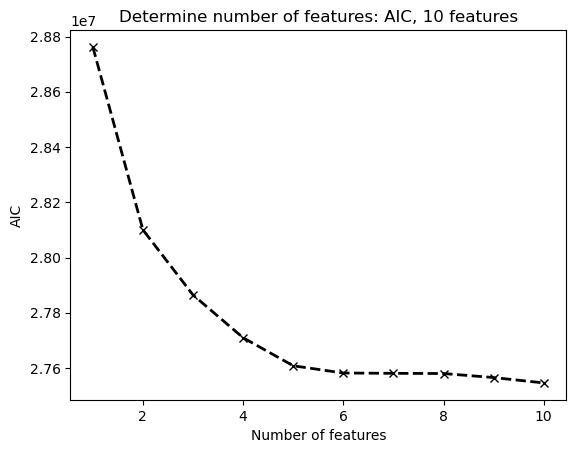

In [38]:
resp = "heartrate_bpm"

y = df3[resp]
X = df3.copy(deep=True)
X.drop(columns=[resp],inplace=True)

AIC = np.zeros(len(X.columns))
lm = LinearRegression()
num_features = np.arange(1,len(df3.columns))
sfs_features = {nf : {} for nf in num_features[:-1]}

for idx,nf in enumerate(num_features[:-1]):
    sfs = SequentialFeatureSelector(lm,n_features_to_select=nf).fit(X,y)
    features = sfs.get_feature_names_out()
    new_X = X[features]
    nf_lm = lm.fit(new_X,y)
    score = nf_lm.score(new_X,y)
    y_pred = nf_lm.predict(new_X)
    mse = mean_squared_error(y,y_pred)
    AIC[idx] = 2.0*nf + len(X) * np.log(2.0*np.pi*(mse ** 2.0)) + len(X)
    sfs_features[nf] = {"score":score, "features": features, "model":nf_lm}
    
nf_lm = lm.fit(X,y)
score = nf_lm.score(X,y)
y_pred = nf_lm.predict(X)
mse = mean_squared_error(y,y_pred)
AIC[-1] = 2.0*num_features[-1] + len(X) * np.log(2.0*np.pi*(mse ** 2.0)) + len(X)

aic_features = np.argmin(AIC) + 1
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_xlabel("Number of features")
ax.set_ylabel("AIC")
ax.set_title(f"Determine number of features: AIC, {aic_features} features")
ax.plot(num_features,AIC,ls="--",lw=2,marker="x",c="k")

In [39]:
import statsmodels.api as sm

features = sfs_features[aic_features-1]["features"]

X2 = X[features]
feature = sm.add_constant(X2)

model = sm.OLS(y, feature)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          heartrate_bpm   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
No. Observations:             1921431   F-statistic:                 2.786e+05
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           124.2834      0.408    304.253      0.000     123.483     125.084
temp_hand        -2.4494      0.009   -269.452      0.000      -2.467      -2.432
temp_ankle        1.1826      0.014     85.404      0.000       1.155       1.210
acc_hand          0.0602      0.003     20.619      0.000       0.054       0.066
acc_chest        -0.1157      0.004    -28.191      0.000      -0.124      -0.108
acc_ankle         0.2287      0.002    118.493      0.000       0.225       0.232
gyr_hand          1.9680      0.010    195.026      0.000       1.948       1.988
gyr_chest        10.0068      0.028    359.175      0.000       9.952      10.061
gyr_ankle         1.9828      0.009    221.120      0.000       1.965       2.000
activity_high    19.2586      0.032    599.952      0.000      19.196      19.322
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the same reasons as mentioned earlier I have slected few parameters.

In [43]:
new_features = [f for f in features if not f in ["temp_chest","temp_ankle","acc_chest","acc_ankle","gyr_chest","gyr_ankle"]]

X2 = X[new_features]
feature = sm.add_constant(X2)

model = sm.OLS(y, feature)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          heartrate_bpm   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
No. Observations:             1921431   F-statistic:                 4.798e+05
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           164.3807      0.282    582.669      0.000     163.828     164.934
temp_hand        -2.3885      0.008   -287.724      0.000      -2.405      -2.372
acc_hand          0.1802      0.003     66.700      0.000       0.175       0.185
gyr_hand          4.0619      0.010    415.823      0.000       4.043       4.081
activity_high    24.8626      0.032    774.272      0.000      24.800      24.926
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above OLS regression result, we can conclude that:

- With decrease in the hand temperature, the chances of heartrate incresing is strong.
- With increase in the activity_high, acceleration and angular velocity of hand, the chances of heartrate incresing is strong too.

it is evident that we can use only 3 parameters to predict the heartrate of the user/subject with an R-squarred(accuracy) of 50% and with confidence interval of 95%.

# IV. Conclusion

In this report, I have examined the relationship between different variables through exploratory data analysis. I have mostly focused on type of activity the user might be preforming since I wanted to predict that. Alos ii wanted to make  device which would predict this based on the sensor values. Moreover, Rope Jumping and running were the most cumbersome activities out of all the activities. Temperature of hand has negative correlation with heartrate whereas angular velocity of hand has positive correlation with heartrate.

Then I used linear regression model to predict the rsponse variable using all other features.

__My actionable insight:__

I have developed two models and hardware design where by only using hand temperature, hand acceleration, hand angular velocity and heartrate, the model can predict the type of activity the user is performing and predict what should be the heartrate based on those features. The dataset that I used had data from various people performing different kinds of activities. I categorized the dataset into two parts such as low intensity tasks(Lying down, Sitting, Standing, Watching TV, Computer work, etc) and high intensity tasks(Vacuuming, Walking, Cycling, Nordic Walking, Running, etc). Since we had only 9 subjects to test on, the information such as sex, weight, age could not give any insights so I have not included them in the analysis or prediction. Also, I removed few features using feature selection based on AIC score because to=hose features wont be helpful in our predictive model.  

This software can be integrated with a smart watch sitting on the user hand with all the necessary sensors and make some prediction on what type of actitvity the user might be performing and what should be the heartrate.

This could be quite helpful in various scenarios such as:

- __Health Monitoring:__  Users can receive real-time feedback on their physical activity as well as having their heart rate calculated, enabling a proactive approach to health and well-being.

- __Optimized Workouts:__ Individuals participating in fitness activities can modify their routines depending on the projected intensity level and adjust their efforts for more effective training.

- __Personalized Training Programs:__ Coaches and fitness trainers can use technology to design individualized training plans for their customers, improving their performance and lowering their risk of injury.

- __Rehabilitation Support:__ For people undergoing physical rehabilitation, the system may analyze their movements and prescribe appropriate activities, increasing the efficacy of therapy.

- __Stress Management:__ Monitoring heart rate and activity types can help with stress management by spotting patterns and providing relaxing techniques as needed.

- __Enhancement of Sleep Quality:__ By examining activity patterns while sleeping, people can better understand and take care of their general health by improving their quality of sleep.

- __Elderly Care:__ The system can help keep an eye on the everyday activities of elderly people, giving caretakers valuable information and guaranteeing their safety and wellbeing.


- __Virtual Reality and Gaming:__ By tailoring content to the user's movements in virtual reality or gaming applications, content can be enhanced to create a more immersive and captivating experience.

In [47]:
filepath='Report2.ipynb'
import io
from nbformat import read
with io.open(filepath, "r", encoding="utf-8") as f:
    nb=read(f, 4)
word_count = 0
for cell in nb["cells"]:
    if cell.cell_type == "markdown":
        word_count += len(cell["source"].replace("#", "").lstrip().split(" "))
print(f"Submission length is {word_count}")

Submission length is 3068
